# Alpha

This notebook investigates the alpha of S&P stocks

### Import & Format Data

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import datetime, timedelta

In [3]:
# S&P index
spy = pd.read_csv('../data/price/SPY.csv', index_col='Date', parse_dates=True)
print('SPY\t\t', spy.shape)

# 10y Treasury yeild
t_bill = pd.read_csv('../data/price/%5ETNX.csv', index_col='Date', parse_dates=True)
t_bill = t_bill.loc[spy.index.intersection(t_bill.index)] # Only select dates valid from SPY
print('10y TBill (raw)\t', t_bill.shape)

diff_index = spy.index.difference(t_bill.index)
nan_df = pd.DataFrame([np.full(6, np.nan) for x in range(diff_index.size)], index=diff_index, columns=t_bill.columns)
t_bill = t_bill.append(nan_df).sort_index()
t_bill = t_bill.interpolate(method='time')

assert t_bill[t_bill.Close.isnull()].index.size == 0 # check all nan's have been filled
print('10y TBill\t', t_bill.shape)

SPY		 (6691, 6)
10y TBill (raw)	 (6672, 6)
10y TBill	 (6691, 6)


In [4]:
# get tickers
tickers = pd.read_csv('../data/spy/tickers.csv', header=None)[1]

# Load all stocks
all_stocks = {}
for ticker in tickers:
    stock = pd.read_csv('../data/price/{}.csv'.format(ticker), index_col='Date', parse_dates=True)
    all_stocks[ticker] = stock

print(len(all_stocks))

505


In [5]:
# get tickers
tickers = pd.read_csv('../data/spy/tickers.csv', header=None)[1]

# Load all stocks
stocks = pd.DataFrame()
for ticker in tickers:
    stock = pd.read_csv('../data/price/{}.csv'.format(ticker), index_col='Date', parse_dates=True)
    stocks[ticker] = stock['Adj Close'].rename(ticker)

stocks = stocks.drop(['APC', 'LHX', 'TMK'], axis=1)
stocks = stocks.interpolate(method='time')

stocks = stocks.loc[spy.iloc[0].name:]
    
print(len(stocks))

6691


In [6]:
df = pd.DataFrame(spy['Adj Close'].rename('price'))
df['pct_change'] = df.price.pct_change()
df['log_return'] = np.log(df.price).diff()
df = df.iloc[1:]
market_returns = df['log_return'].rename('market_returns')

In [7]:
# get returns for all sotcks
stocks_returns = np.log(stocks).diff().iloc[1:]

assert market_returns.index[0] == stocks_returns.index[0], "Initial dates do not match: {} {}".format(market_returns.index[0], stocks_returns.index[0])
assert market_returns.shape[0] == stocks_returns.shape[0], "Sizes do not match: {} {}".format(market_returns.shape[0], stocks_returns.shape[0])

In [8]:
from data.info import info
stock_info = info.load()

### Calculate Beta

In [9]:
def calc_betas(x_name, window, returns_data):
    window_inv = 1.0 / window
    x_sum = returns_data[x_name].rolling(window, min_periods=window).sum()
    y_sum = returns_data.rolling(window, min_periods=window).sum()
    xy_sum = returns_data.mul(returns_data[x_name], axis=0).rolling(window, min_periods=window).sum()
    xx_sum = np.square(returns_data[x_name]).rolling(window, min_periods=window).sum()
    xy_cov = xy_sum - window_inv * y_sum.mul(x_sum, axis=0)
    x_var = xx_sum - window_inv * np.square(x_sum)
    betas = xy_cov.divide(x_var, axis=0)[window - 1:]
    betas.columns.name = None
    return betas

In [10]:
returns_data = pd.concat([market_returns, stocks_returns], axis=1)

betas = calc_betas('market_returns', 22 * 6, returns_data).drop('market_returns', axis=1)

In [11]:
def get_ndays_return(daily_returns, ndays=22):
    ndays_returns = (1 + daily_returns).rolling(ndays, min_periods=ndays).apply(np.prod, raw=True) - 1
    return ndays_returns.iloc[ndays-1:]


time_frame = 22 * 6

stocks_monthly_returns = get_ndays_return(stocks_returns, time_frame)
market_monthly_returns = get_ndays_return(market_returns, time_frame)
risk_free_returns = np.log(t_bill['Adj Close']).diff().iloc[1:]
risk_free_monthly = get_ndays_return(risk_free_returns, time_frame)

print(stocks_monthly_returns.shape)
print(market_monthly_returns.shape)
print(risk_free_monthly.shape)

(6559, 502)
(6559,)
(6559,)


### Calcuate Alpha

In [12]:
# alpha = return - risk_free - beta * (market - risk_free)

returns_over_risk_free = stocks_monthly_returns.subtract(risk_free_monthly, axis=0)
market_over_risk_free  = market_monthly_returns - risk_free_monthly
beta_market_risk_free  = betas.multiply(market_over_risk_free, axis=0)

alpha = returns_over_risk_free - beta_market_risk_free.values

c:\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


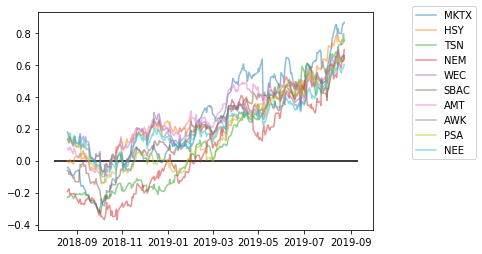

In [13]:
large_alpha = alpha.iloc[-1].nlargest(10)

for stock in large_alpha.index:
    plt.plot(alpha[stock][-255:], alpha=.5, label=stock)

xmin, xmax = plt.xlim()
plt.hlines(0, xmin, xmax)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [14]:
from tools.fin_calc import log_returns, top_alpha

stocks_returns = log_returns(stocks)
market_returns = log_returns(spy['Adj Close']).rename('market_returns')
risk_free_returns = log_returns(t_bill['Adj Close']).rename('risk_free_returns')

time_frame = 22 * 6
top_alpha(stocks_returns, market_returns, risk_free_returns, time_frame, 10)

MKTX    0.866360
HSY     0.752906
TSN     0.750369
NEM     0.694310
WEC     0.657954
SBAC    0.653106
AMT     0.638881
AWK     0.634763
PSA     0.632887
NEE     0.602564
Name: 2019-08-23 00:00:00, dtype: float64